# Physics-Informed Neural Networks

Original [paper](https://www.sciencedirect.com/science/article/pii/S0021999118307125) by M.Raissi et al. 

In complex physical, biological or engineering systems, obtaining data is sometimes unachievable. State of the art machine learning techniques cannot provide any guarantee of convergence given the lack of training data. 

**Traditional physics model** creation is a task of a domain expert, who parametrises physics models to best fit a system of interest. For example, creating a model of aircraft dynamics using equations of drag, lift, gravity, thrust, etc., and parametrising the model to attempt to closely match the model to a specific aircraft.

However, sometimes physical systems are hard to parametrise and there does not exist a closed form solution. 

In [9]:
import numpy as np
import scipy.io

import jax.numpy as jnp
from jax import value_and_grad, jit, random, vmap
import optax

KEY = random.PRNGKey(1)

## Import Schrodinger Data

In [28]:
data = scipy.io.loadmat("original_paper/Data/NLS.mat")

lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])
N0 = 50
N_b = 50
N_f = 20000

t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
u = np.real(data['uu'])
v = np.imag(data['uu'])
h = np.sqrt(u**2 + v**2)

# Initial Condition Data
idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x,:]
t0 = np.zeros(x0.shape)
u0 = u[idx_x,0:1]
v0 = v[idx_x,0:1]

# Boundary Condition Data
idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t,:]

In [30]:
X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb), lower bound
X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb), upper bound
# Boundary condition data; lb for lower bound, ub for upper bound
x_lb = X_lb[:,0:1]
t_lb = X_lb[:,1:2]
x_ub = X_ub[:,0:1]
t_ub = X_ub[:,1:2]

## Visualizing Our Testing Data

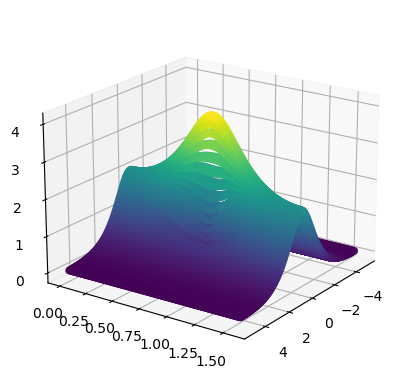

In [73]:
import matplotlib.pyplot as plt

T, X = np.meshgrid(t,x)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(20, 35)
ax.scatter(X, T, h, c=h, cmap='viridis');

## Traditional MLP

First implement `init_params` and `forward`

In [3]:
def init_params(layers, key=KEY):
    '''
    Initialize parameters in the MLP. Weights are initialized
    using Xavier initialization, while biases are zero initialized.

    Returns
    - params: the initialized parameters
    '''
    def xavier_init(input_dim, output_dim, key=key):
        '''Use Xavier initialization for weights of a single layer'''
        std_dev = jnp.sqrt(2/(input_dim + output_dim)) # compute standard deviation for xavier init
        w = std_dev * random.normal(key, (input_dim, output_dim)) # initialize the weights
        return w

    params = []

    for l in range(len(layers) - 1):
        w = xavier_init(layers[l], layers[l+1]) # xavier initialize the weight
        b = jnp.zeros(layers[l+1]) # zero initialize the bias
        params.append((w, b)) # append weight and bias for this layer to params
    
    return params


def forward(params, x):
    '''
    Forward pass through the MLP. In PINN, the nonlinearity are
    applied using tanh.

    Arguments
    - params: weights and biases for all layers of MLP
    - x: input to the MLP

    Returns
    - out: output of the MLP
    '''
    activations = x
    for w, b in params[:-1]:
        out = jnp.dot(activations, w) + b # Perform linear operation
        activations = jnp.tanh(out) # apply tanh activation
    
    final_w, final_b = params[-1]
    out = jnp.dot(activations, final_w) + final_b # Do not apply nonlinearity to last layer
    return out

batched_forward = vmap(forward, in_axes=(None, 0))

Test implementation for `init_param` and `forward`.

In [4]:
layers = [2, 10, 1]
x = random.uniform(KEY, (5, 2))
out = batched_forward(init_params(layers), x)
expected = jnp.array([[-0.05742961],
                     [-0.08960884],
                     [-0.04750253],
                     [-0.17843515],
                     [-0.09102767]])
assert jnp.allclose(out, expected)

Now implement `mseloss` and `update`

In [5]:
def mseloss(params, x, true):
    pred = batched_forward(params, x)
    return jnp.mean(jnp.square(pred - true))

def fit(params, optimizer, X, Y):
    opt_state = optimizer.init(params)

    @jit
    def step(params, opt_state, x, y):
        loss_value, grads = value_and_grad(mseloss)(params, x, y)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    for i, (x, y) in enumerate(zip(X, Y)):
        params, opt_state, loss_value = step(params, opt_state, x, y)
        print(f'step {i}, loss: {loss_value}')

    return params

In [6]:
layers = [5, 10, 10, 1]
X = random.uniform(KEY, (20, 5))
Y = random.uniform(KEY, (20, 1))

optimizer = optax.adam(learning_rate=1e-2)
trained_params = fit(init_params(layers), optimizer, X, Y)

step 0, loss: 0.10777242481708527
step 1, loss: 0.12940318882465363
step 2, loss: 0.1437758356332779
step 3, loss: 0.02379879727959633
step 4, loss: 0.36217206716537476
step 5, loss: 0.05129792168736458
step 6, loss: 0.00623120553791523
step 7, loss: 0.026975566521286964
step 8, loss: 0.006425472907721996
step 9, loss: 0.0036361755337566137
step 10, loss: 0.13369491696357727
step 11, loss: 0.1718134582042694
step 12, loss: 0.27841946482658386
step 13, loss: 0.034345757216215134
step 14, loss: 0.1644914746284485
step 15, loss: 0.04430651664733887
step 16, loss: 0.15023164451122284
step 17, loss: 0.002893552416935563
step 18, loss: 0.08664584904909134
step 19, loss: 0.02422439493238926


In [7]:
mseloss(trained_params, X, Y)

DeviceArray(0.07618722, dtype=float32)